<a href="https://colab.research.google.com/github/kahinasassi/Deep-learning-models-to-sentiment-analysis-in-alg-rian-dialects/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
import numpy as np
import pandas as pd
import nltk
from nltk import re
from nltk import defaultdict
import io
from keras.models import Model

import codecs
import csv
import pickle
import nltk
import time
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D 
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import scikitplot as skplt
import h5py
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional ,Conv1D, Dropout  ,MaxPooling1D,Flatten,Concatenate
from keras.layers import TimeDistributed
import keras
from keras.optimizers import Adam , SGD, RMSprop
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Embedding, Conv1D, MaxPool1D
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# ouvrir un fichier pickle
def open_pickle(path):
  with open(path, 'rb') as handle: 
    doc= pickle.load(handle)
    return doc

def save_pickle(variable,filename):
    with open(filename, 'wb') as handle:
         pickle.dump(variable, handle, protocol=pickle.HIGHEST_PROTOCOL)
#modified
from keras import backend as K

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall

def fmeasure(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision
    
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

#  optimizer
sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
rms_prop = keras.optimizers.RMSprop(lr=1e-4)
#opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)

adamax = keras.optimizers.Adamax(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)


#*********************************************Accuaracy and loss*******************************
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# 1 Ensemble de données

## Remarque: décommenter 1 seul ensemble de données à testet

# Mataoui originale: 2classes

In [ ]:
#data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/mataouiOrg.pickle")
'''
data.info()
print('**********************************************************************')
print(data.shape)
print('**********************************************************************')
#print(data.label.value_counts())
print("nbr de val positives = ",len(data.loc[data['label'] == 1].iloc[:,1]))
print("nbr de val negatives = ",len(data.loc[data['label'] == -1].iloc[:,1]))
print("nbr de val neutres = ",len(data.loc[data['label'] == 0].iloc[:,1]))
print("**********************************************************************")
print("les valeurs nuls:\n", data.isnull().sum())
data = pd.DataFrame(data)'''

# Mataoui avec 3 classes

In [ ]:
#data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/dataMataoui.pickle")
'''
data.info()
print('**********************************************************************')
print(data.shape)
print('**********************************************************************')
#print(data.label.value_counts())
print("nbr de val positives = ",len(data.loc[data['label'] == 1].iloc[:,1]))
print("nbr de val negatives = ",len(data.loc[data['label'] == -1].iloc[:,1]))
print("nbr de val neutres = ",len(data.loc[data['label'] == 0].iloc[:,1]))
print("**********************************************************************")
print("les valeurs nuls:\n", data.isnull().sum())
data = pd.DataFrame(data)'''

# BrandtDz

In [ ]:
#data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/BRANDT.pickle")
'''
data.info()
print('**********************************************************************')
print(data.shape)
print('**********************************************************************')
#print(data.label.value_counts())
print("nbr de val positives = ",len(data.loc[data['label'] == 1].iloc[:,1]))
print("nbr de val negatives = ",len(data.loc[data['label'] == -1].iloc[:,1]))
print("nbr de val neutres = ",len(data.loc[data['label'] == 0].iloc[:,1]))
print("**********************************************************************")
print("les valeurs nuls:\n", data.isnull().sum())
data = pd.DataFrame(data)'''

# Madar+ YouTube

In [ ]:
#data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/data_mixed.pickle")
'''
data.info()
print('**********************************************************************')
print(data.shape)
print('**********************************************************************')
#print(data.label.value_counts())
print("nbr de val positives = ",len(data.loc[data['label'] == 1].iloc[:,1]))
print("nbr de val negatives = ",len(data.loc[data['label'] == -1].iloc[:,1]))
print("nbr de val neutres = ",len(data.loc[data['label'] == 0].iloc[:,1]))
print("**********************************************************************")
print("les valeurs nuls:\n", data.isnull().sum())
data = pd.DataFrame(data)'''

# dataset rassemblé

In [ ]:
data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/finale_data.pickle")
'''
data.info()
print('**********************************************************************')
print(data.shape)
print('**********************************************************************')
#print(data.label.value_counts())
print("nbr de val positives = ",len(data.loc[data['label'] == 1].iloc[:,1]))
print("nbr de val negatives = ",len(data.loc[data['label'] == -1].iloc[:,1]))
print("nbr de val neutres = ",len(data.loc[data['label'] == 0].iloc[:,1]))
print("**********************************************************************")
print("les valeurs nuls:\n", data.isnull().sum())
data = pd.DataFrame(data)'''

'\ndata.info()\nprint(\'**********************************************************************\')\nprint(data.shape)\nprint(\'**********************************************************************\')\n#print(data.label.value_counts())\nprint("nbr de val positives = ",len(data.loc[data[\'label\'] == 1].iloc[:,1]))\nprint("nbr de val negatives = ",len(data.loc[data[\'label\'] == -1].iloc[:,1]))\nprint("nbr de val neutres = ",len(data.loc[data[\'label\'] == 0].iloc[:,1]))\nprint("**********************************************************************")\nprint("les valeurs nuls:\n", data.isnull().sum())\ndata = pd.DataFrame(data)'

# ensemble de données équilibere

In [ ]:
 
'''
data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/ressources/finale_data.pickle")

data = pd.DataFrame(data)
pos = data[data['label'] ==1]
neg = data[data['label'] == -1]
neu = data[data['label'] == 0]

max_len = min(len(pos), len(neg), len(neu))

data_ = []
for i in range(max_len):
  data_ += [{'text' : pos.iloc[i]['text'], 'label' : pos.iloc[i]['label']}]
  data_ += [{'text' : neg.iloc[i]['text'], 'label' : neg.iloc[i]['label']}]
  data_ += [{'text' : neu.iloc[i]['text'], 'label' : neu.iloc[i]['label']}]

data = pd.DataFrame(data_)

'''



"\npos = data[data['label'] ==1]\nneg = data[data['label'] == -1]\nneu = data[data['label'] == 0]\n\nmax_len = min(len(pos), len(neg), len(neu))\n\ndata_ = []\nfor i in range(max_len):\n  data_ += [{'text' : pos.iloc[i]['text'], 'label' : pos.iloc[i]['label']}]\n  data_ += [{'text' : neg.iloc[i]['text'], 'label' : neg.iloc[i]['label']}]\n  data_ += [{'text' : neu.iloc[i]['text'], 'label' : neu.iloc[i]['label']}]\n\ndata = pd.DataFrame(data_)\n\n"

# Traitement

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['label'], train_size=0.90)

texte = X_train.append(X_test)

# Encodage du text

In [ ]:
from collections import Counter

# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(texte)
num_words = len(counter)# we 'll use it to vocab 

# Max number of words in a sequence
max_length = 60
print('vocab=', len(counter),' and max_length=',max_length)

vocab= 42404  and max_length= 60


In [ ]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences( train_sequences, maxlen=max_length, padding="post", truncating="post")

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(  test_sequences, maxlen=max_length, padding="post", truncating="post")

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])
decode(train_sequences[0])

#len(valid_padded)

'انت لىس حظ رسرذ عظم'

# Encodage des labels

In [ ]:


from keras.utils import to_categorical

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

y_train.shape

(18824, 3)

# Architecture

## 2 couches LSTM

In [ ]:
model=Sequential()
model.add(Embedding(num_words,100,input_shape= (train_padded.shape[1],),mask_zero=True))
model.add(SpatialDropout1D(0.40))
model.add(LSTM(16,dropout=0.1, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(8))

#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3,activation='softmax'))

# Compilation

In [ ]:

#  optimizer
sgd = keras.optimizers.SGD(lr=0.001, momentum=0.9)
rms_prop = keras.optimizers.RMSprop(lr=0.0001)
opt = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)

adamax = keras.optimizers.Adamax(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
model.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ['accuracy', recall, precision, fmeasure])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           4240400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 16)            7488      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 4,248,715
Trainable params: 4,248,715
Non-trainable params: 0
____________________________________________

# Entrainement

In [ ]:
history = model.fit(train_padded, y_train, epochs=50, batch_size=100,validation_split=0.10,callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])


Epoch 1/50
170/170 [==============================] - 32s 189ms/step - loss: 1.0960 - accuracy: 0.3973 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.0925 - val_accuracy: 0.4068 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 2/50
170/170 [==============================] - 31s 180ms/step - loss: 1.0850 - accuracy: 0.4415 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.0762 - val_accuracy: 0.4716 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 3/50
170/170 [==============================] - 31s 180ms/step - loss: 1.0610 - accuracy: 0.4863 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.0514 - val_accuracy: 0.4992 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 4/50
170/170 [==============================] - 30s 177ms/step - loss: 1.0108 - accuracy: 0.5475 - recall: 0.0171 -

In [ ]:
result = model.evaluate(x=test_padded, y= y_test)
print('Accuracy:', result[1])
print('LOSS:', result[2])

66/66 [==============================] - 1s 16ms/step - loss: 0.8346 - accuracy: 0.6831 - recall: 0.6799 - precision: 0.7704 - fmeasure: 0.7119
Accuracy: 0.683078408241272
LOSS: 0.6798620820045471


# Evaulation

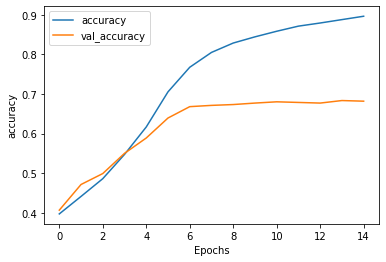

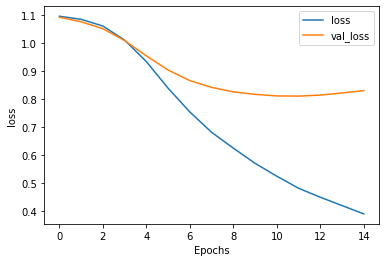

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:


from sklearn.metrics import classification_report
Y_pred = model.predict(test_padded)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

print(classification_report(Y_true,Y_pred_classes))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       669
           1       0.73      0.75      0.74       812
           2       0.68      0.58      0.62       611

    accuracy                           0.68      2092
   macro avg       0.68      0.67      0.68      2092
weighted avg       0.68      0.68      0.68      2092



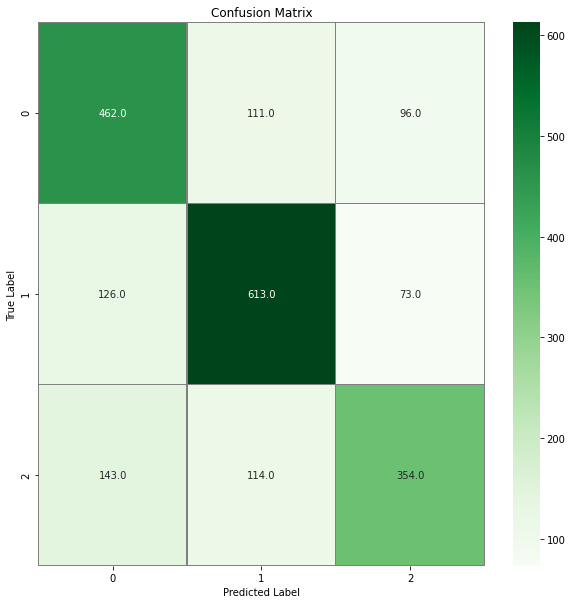

In [ ]:


# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
Y_pred = model.predict(test_padded)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# sauvgarde

In [ ]:

def savemodel(model,name):
  model.save('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/CODE/'+name)
def open_model(name):
  return keras.models.load_model('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/CODE/'+name)